In [123]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import os
import pandas as pd
import seaborn as sns
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures
import gzip
import json
import datetime

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [3]:
allRatings = []

In [4]:
with gzip.open('Video_Games_5.json.gz', 'rb') as f:
    # Decompress the file
    for line in f:
        # Parse the JSON data
        data = json.loads(line)
        # Now you can use the data as a Python object
        allRatings.append(data)

In [5]:
allRatings[0]

{'overall': 5.0,
 'verified': True,
 'reviewTime': '10 17, 2015',
 'reviewerID': 'A1HP7NVNPFMA4N',
 'asin': '0700026657',
 'reviewerName': 'Ambrosia075',
 'reviewText': "This game is a bit hard to get the hang of, but when you do it's great.",
 'summary': "but when you do it's great.",
 'unixReviewTime': 1445040000}

In [6]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)
ratingsPerUserItemList = list()

for d in allRatings:
    ratingsPerUser[d['reviewerID']].append((d['asin'],d['overall']))
    ratingsPerItem[d['asin']].append((d['reviewerID'],d['overall']))

In [92]:
df = pd.DataFrame(allRatings)

missingness test + fairness test on verified vs unverified

## Cleaning and EDA

#### Data Cleaning

In [93]:
df = df.rename(columns={'reviewerID': 'reviewer_id'})

In [94]:
# number of users
df['reviewer_id'].nunique()

55223

In [95]:
# number unique names
df['reviewerName'].nunique()

45943

In [96]:
# number of products
df['asin'].nunique()

17408

In [97]:
df['reviewTime'] = pd.to_datetime(df['unixReviewTime'],unit='s')


In [98]:
df.isna().mean()

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewer_id       0.000000
asin              0.000000
reviewerName      0.000153
reviewText        0.000318
summary           0.000219
unixReviewTime    0.000000
vote              0.783364
style             0.418709
image             0.992697
dtype: float64

In [99]:
df[~df['image'].isna()]['image'].iloc[0]

['https://images-na.ssl-images-amazon.com/images/I/51LAK7qaoVL._SY88.jpg']

In [100]:
df['vote'] = df['vote'].fillna('0').transform(lambda x: int(x.replace(',', '')))

In [101]:
df.isna().mean()

overall           0.000000
verified          0.000000
reviewTime        0.000000
reviewer_id       0.000000
asin              0.000000
reviewerName      0.000153
reviewText        0.000318
summary           0.000219
unixReviewTime    0.000000
vote              0.000000
style             0.418709
image             0.992697
dtype: float64

In [18]:
# rename index
df.index.names = ['review_id']

In [19]:
# finding product with most useful reviews
productWithMostHelpfulReview = df.groupby(['asin'])['vote'].max().idxmax()

In [20]:
# Most Reviews per Product as Popularity Metric
mostReviewedProducts = df.groupby('asin')['verified'].count().rename('Review Count').sort_values(ascending=False)

The most popular game of all time is B00178630A, *Diablo III*

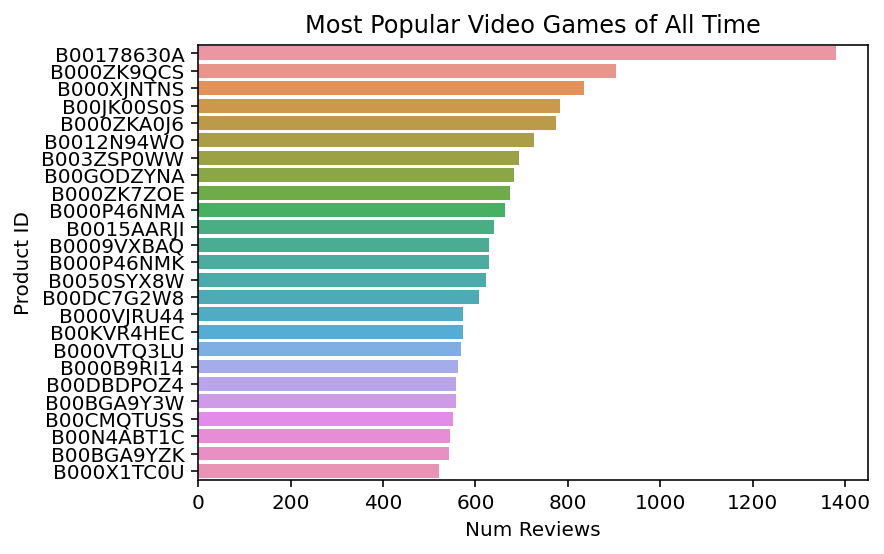

In [21]:
sns.barplot(y=mostReviewedProducts.keys()[:25],x=mostReviewedProducts.values[:25],orient='h')

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Num Reviews')
ax.set_ylabel('Product ID')
ax.set_title('Most Popular Video Games of All Time')

# Show the plot
plt.show()

In [22]:
# Reviews per Product within Last Week, Month, and Year
latestDate = df['reviewTime'].max()
lastWeekReviews = df[latestDate - df['reviewTime'] <= pd.to_timedelta(7, unit='days')]
lastMonthReviews = df[latestDate - df['reviewTime'] <= pd.to_timedelta(30, unit='days')]
lastYearReviews = df[latestDate - df['reviewTime'] <= pd.to_timedelta(365, unit='days')]

In [23]:
# Querying most recent popular post by last week, month, and year
mostPopularProducts_lastWeek = lastWeekReviews.groupby('asin')['verified'].count().rename('Review Count').sort_values(ascending=False)

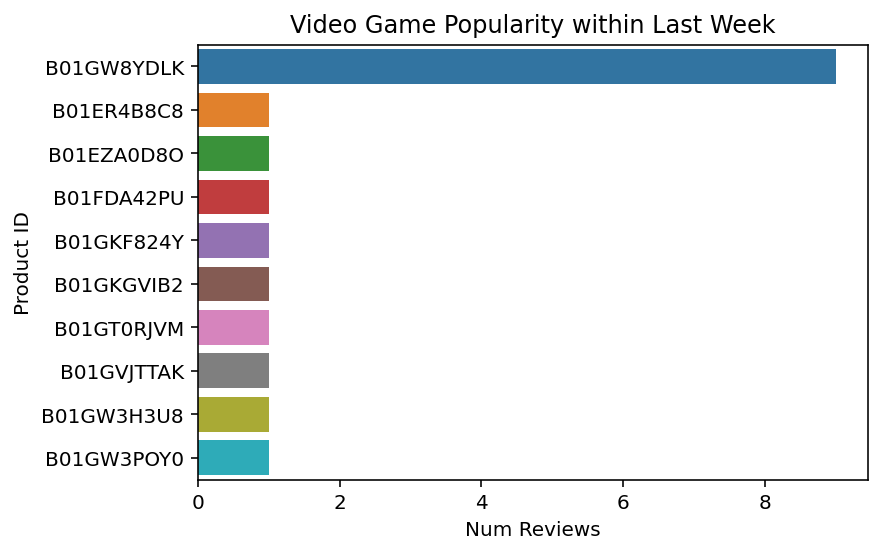

In [24]:
sns.barplot(y=mostPopularProducts_lastWeek.keys(),x=mostPopularProducts_lastWeek.values,orient='h')

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Num Reviews')
ax.set_ylabel('Product ID')
ax.set_title('Video Game Popularity within Last Week')

# Show the plot
plt.show()

In [25]:
mostPopularProducts_lastMonth = lastMonthReviews.groupby('asin')['verified'].count().rename('Review Count').sort_values(ascending=False)

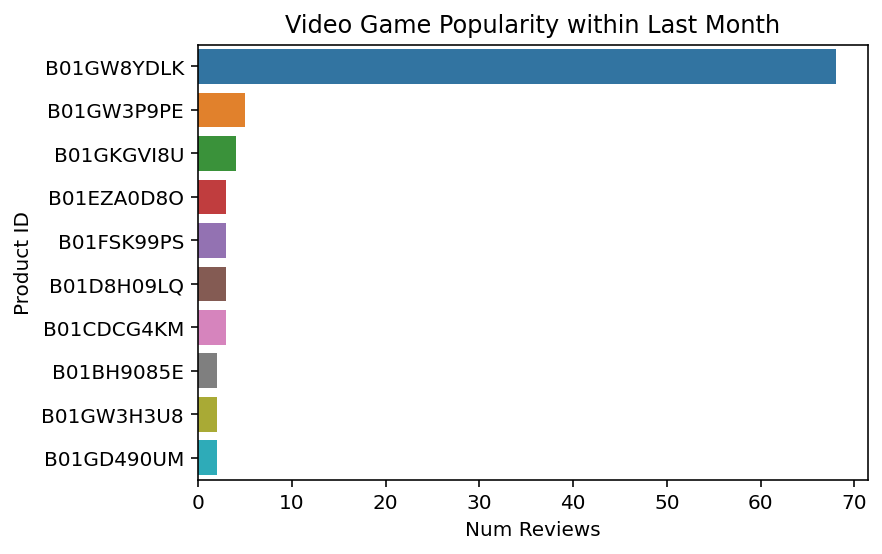

In [26]:
sns.barplot(y=mostPopularProducts_lastMonth.keys()[:10],x=mostPopularProducts_lastMonth.values[:10],orient='h')

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Num Reviews')
ax.set_ylabel('Product ID')
ax.set_title('Video Game Popularity within Last Month')

# Show the plot
plt.show()

In [27]:
mostPopularProducts_lastYear = lastYearReviews.groupby('asin')['verified'].count().rename('Review Count').sort_values(ascending=False)

The most popular game within the last year of the data set was B01GW3P9PE, *God of War 4*

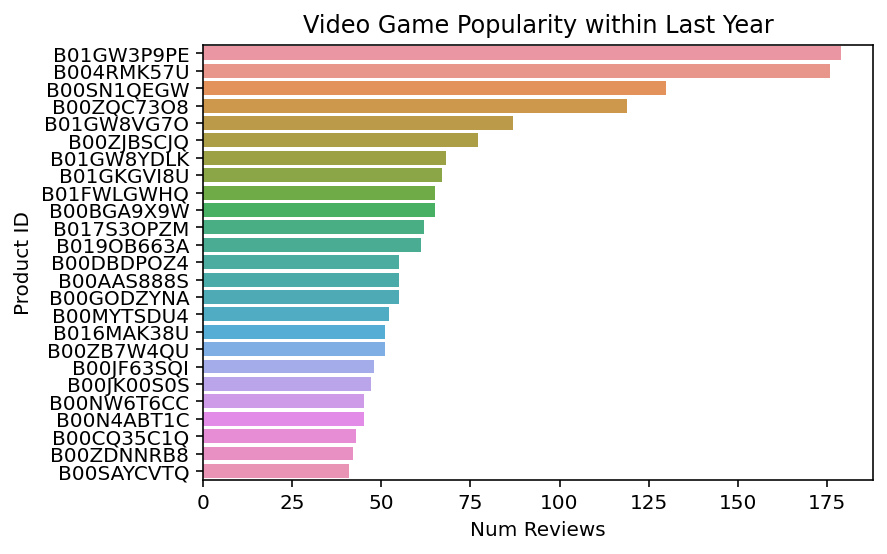

In [28]:
sns.barplot(y=mostPopularProducts_lastYear.keys()[:25],x=mostPopularProducts_lastYear.values[:25], orient='h')

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Num Reviews')
ax.set_ylabel('Product ID')
ax.set_title('Video Game Popularity within Last Year')

# Show the plot
plt.show()

In [29]:
# Most Frequent Posting Users
numReviewsPerUser = df.groupby('reviewer_id')['verified'].count().rename('Reviews per User').sort_values(ascending=False)

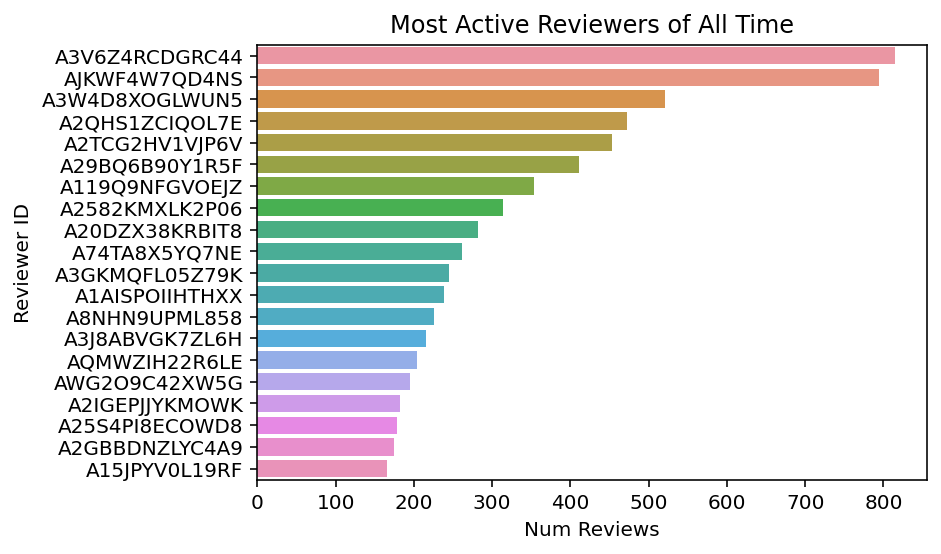

In [110]:
sns.barplot(y=numReviewsPerUser.keys()[:20],x=numReviewsPerUser.values[:20],orient='h')

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Num Reviews')
ax.set_ylabel('Reviewer ID')
ax.set_title('Most Active Reviewers of All Time')

# Show the plot
plt.show()

In [111]:
numReviewsPerUser_LastYear = lastYearReviews.groupby('reviewer_id')['verified'].count().rename('Reviews per User').sort_values(ascending=False)

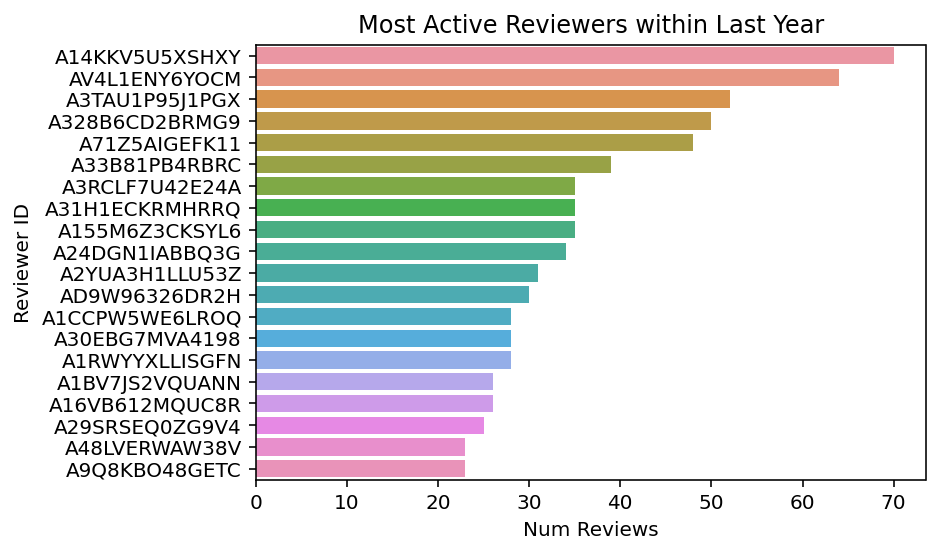

In [112]:
sns.barplot(y=numReviewsPerUser_LastYear.keys()[:20],x=numReviewsPerUser_LastYear.values[:20],orient='h')

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Num Reviews')
ax.set_ylabel('Reviewer ID')
ax.set_title('Most Active Reviewers within Last Year')

# Show the plot
plt.show()

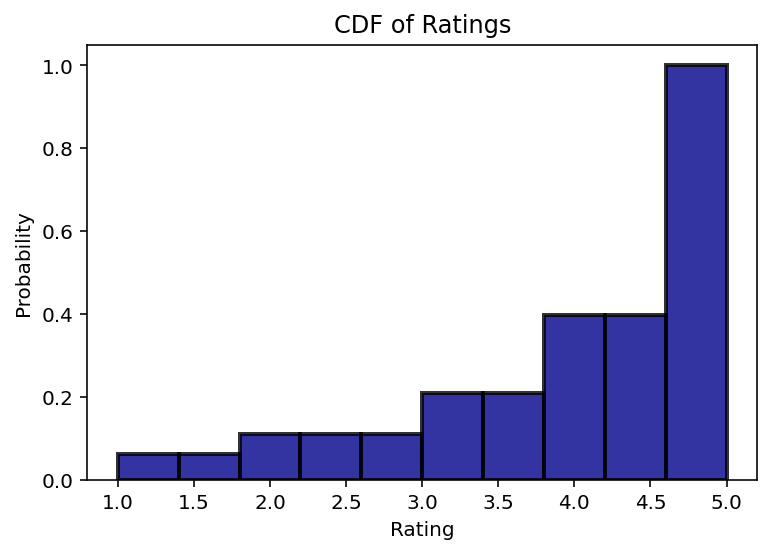

In [33]:
plt.hist(df['overall'], density=True, cumulative=True, histtype='bar', alpha=0.8, color='#00008B', label='CDF',edgecolor='black',linewidth=2);
plt.xlabel('Rating');
plt.ylabel('Probability');
plt.title('CDF of Ratings');

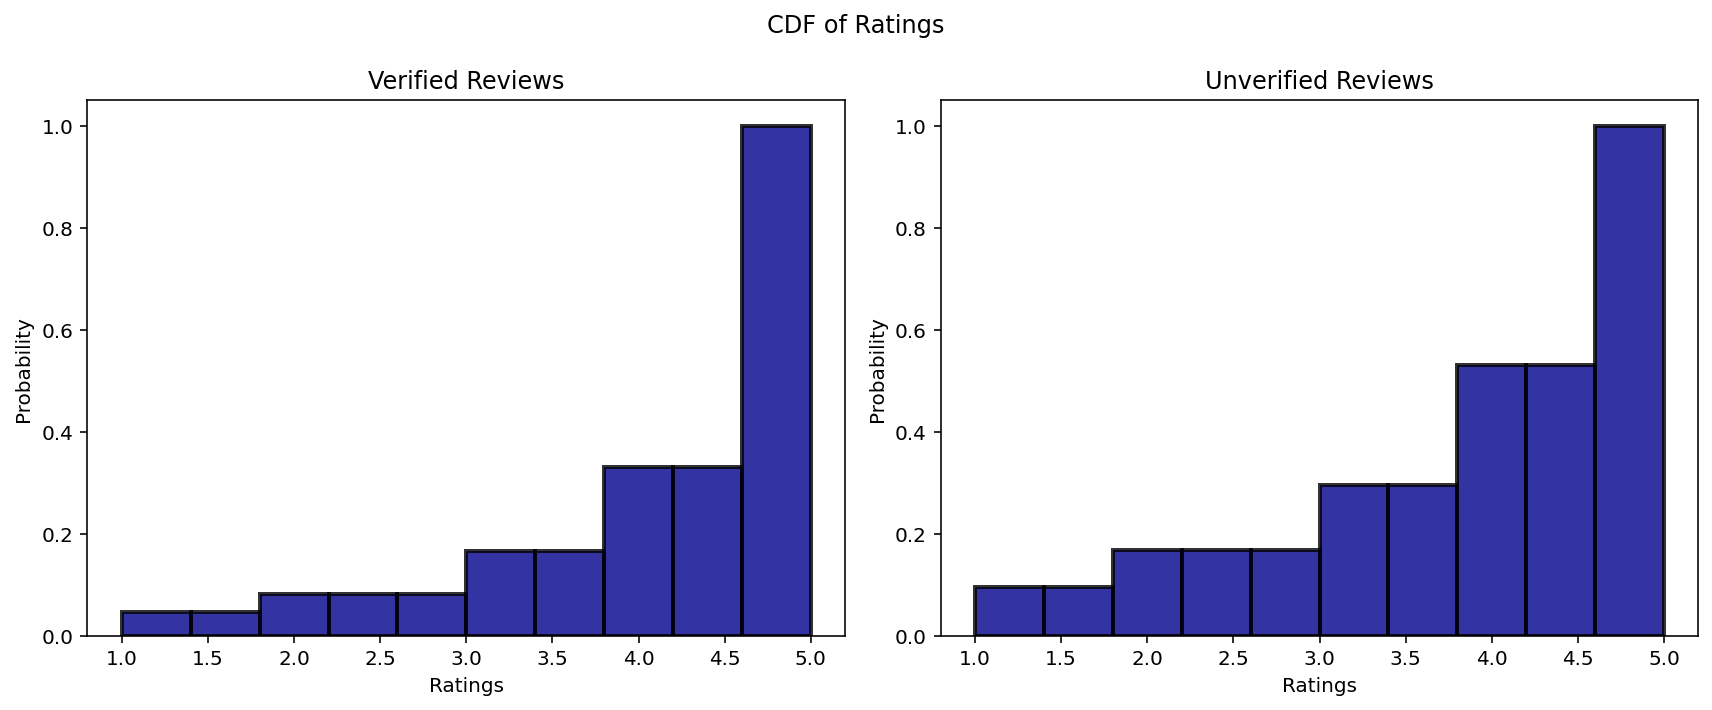

In [34]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

plt.suptitle('CDF of Ratings');

axs[0].hist(df[df['verified']]['overall'], density=True, cumulative=True, histtype='bar', alpha=0.8, color='#00008B', label='CDF',edgecolor='black',linewidth=2);
axs[0].set_title('Verified Reviews')

axs[1].hist(df[~df['verified']]['overall'], density=True, cumulative=True, histtype='bar', alpha=0.8, color='#00008B', label='CDF',edgecolor='black',linewidth=2);
axs[1].set_title('Unverified Reviews')

for ax in axs.flat:
    ax.set(xlabel='Ratings', ylabel='Probability')
    
fig.tight_layout()
plt.show()

The two CDF's appear to have different distributions. We can perform a Kolmogorov–Smirnov test to check if the difference in distributions is statistically significant.

In [35]:
# sort by reviewer_id and time
# only includes reviewers who left more than one review
df_time = df.groupby('reviewTime').filter(lambda x: len(x) > 1).sort_values(by = ['reviewer_id', 'reviewTime'])

In [36]:
# Average time between reviews / user retention metric
avgTime = (df_time.groupby('reviewer_id')['reviewTime'].max() - df_time.groupby('reviewer_id')['reviewTime'].min()) / df_time.groupby('reviewer_id')['reviewTime'].count()

In [120]:
pd.DataFrame(avgTime.head())

,reviewTime
reviewer_id,
A0059486XI1Z0P98KP35,286 days 19:12:00
A0220159ZRNBTRKLG08H,17 days 00:00:00
A0266076X6KPZ6CCHGVS,110 days 06:51:25.714285714
A0277912HT4JSJKVSL3E,48 days 21:36:00
A02836981FYG9912C66F,95 days 00:00:00


In [37]:
# days since last review
left = pd.DataFrame(avgTime.keys())
right = pd.DataFrame(avgTime.values.astype('datetime64[ns]'))
daysSinceLastReview = left.join(right, how='left').rename(columns={0:'days'}).set_index('reviewer_id')
daysSinceLastReview['days'] = daysSinceLastReview['days'].transform(lambda x: x.day)
display(daysSinceLastReview.head())

,days
reviewer_id,
A0059486XI1Z0P98KP35,14
A0220159ZRNBTRKLG08H,18
A0266076X6KPZ6CCHGVS,21
A0277912HT4JSJKVSL3E,18
A02836981FYG9912C66F,6


In [38]:
display(pd.DataFrame(daysSinceLastReview.describe()))

,days
count,55223.000000
mean,13.172193
std,9.485187
min,1.000000
25%,4.000000
50%,12.000000
75%,21.000000
max,31.000000


## Normalizing Relational Database

In [39]:
style = df[~df['style'].isna()]['style']

In [40]:
styleColumns = pd.Series([list(i.keys()) for i in style]).explode().unique()

In [41]:
allImages = pd.DataFrame(df[~df['image'].isna()]['image'].explode())

In [42]:
imgs = set()
for tpl in zip(list(allImages.index), allImages['image']):
    imgs.add(tpl)

In [43]:
cleanedImages = pd.DataFrame(imgs).sort_values(by=0)
cleanedImages = cleanedImages.reset_index(drop=True)

In [44]:
cleanedImages.to_csv('images.csv', header=False)

In [45]:
stylesExpanded = df[~df['style'].isna()][['asin', 'style']]

In [46]:
styleColumns

array(['Format:', 'Platform:', 'Edition:', 'Color:', 'Size:', 'Style:',
       'Length:', 'Subscription Length:', 'Content:', 'Package Type:',
       'Package Quantity:', 'Item Package Quantity:', 'Pattern:',
       'Platform for Display:', 'Style Name:', 'Denomination:',
       'Offer Type:', 'Configuration:', 'Color Name:'], dtype=object)

In [47]:
stylesExpanded

,asin,style
review_id,,
46,0804161380,{'Format:': ' Hardcover'}
47,0804161380,{'Format:': ' Hardcover'}
48,0804161380,{'Format:': ' Hardcover'}
49,0804161380,{'Format:': ' Hardcover'}
50,0804161380,{'Format:': ' Hardcover'}
...,...,...
497564,B01HDJFJOM,{'Platform:': ' PC'}
497565,B01HDJFJLK,{'Platform:': ' PlayStation 4'}
497573,B01HH6JEOC,"{'Edition:': ' Kids Room', 'Platform:': ' PC O..."


In [48]:
'''
param: series
output: set
'''
def cleanVals(ser):
    history = set()
    for vals in ser:
        valList = list(vals.values())
        for v in valList:
            v = str.strip(v.replace(',', ''))
            if v not in history:
                history.add(v)
    return history

In [49]:
stylesValuesCleaned = list(cleanVals(stylesExpanded['style']))

In [50]:
stylesTable = pd.DataFrame(pd.Series({i: stylesValuesCleaned[i] for i in range(len(stylesValuesCleaned))})).rename(columns={0:'Style'})

In [51]:
stylesTable.index.name = 'style_id'

In [52]:
stylesTable.head()

,Style
style_id,
0,Battery & Cable
1,Brozone Color Shell
2,Wham Shell
3,Vanguard
4,Bomb Black


In [131]:
reviewStyle.reset_index().groupby('style_id').count().sort_values(by='review_id', ascending=False)

,review_id
style_id,
1213,129405
509,38480
1850,16647
433,15952
444,15809
...,...
1327,4
1269,4
835,4


In [53]:
# stylesTable.to_csv('styles.csv', header=False)

In [54]:
keyVals = {x: y for x, y in zip(stylesExpanded['asin'], stylesExpanded['style'])}

In [55]:
stylesDict = {val: i for i, val in zip(stylesTable.index, stylesTable['Style'])}

In [56]:
productsTable = pd.DataFrame(columns=['asin', 'style_id'])

In [57]:
hist = set()
for key in keyVals:
    for val in keyVals[key]:
        vals = list(keyVals[key].values())
        for v in vals:
            dct = {'asin': key, 'style_id': stylesDict[str.strip(v).replace(',','')]}
            if str(dct) not in hist:
                hist.add(str(dct))
                row = pd.Series(dct)
                productsTable = productsTable.append(row,ignore_index=True)

In [58]:
productsTable.index.name = 'id'

In [59]:
productsTable.head()

,asin,style_id
id,,
0,0804161380,1074
1,8176503290,661
2,B000003SQQ,41
3,B000006OWS,1213
4,B000006OVF,1213


In [60]:
# productsTable.to_csv('products.csv', header=False)

In [61]:
reviewStyle = df.reset_index().merge(productsTable, on = 'asin', how='left')[['review_id', 'style_id']].dropna().set_index('review_id')
reviewStyle.head()

,style_id
review_id,
46,1074
47,1074
48,1074
49,1074
50,1074


In [64]:
# reviewStyle.to_csv('reviewStyle.csv', header=False)

In [105]:
reviewsTable = df[['overall', 'verified', 'reviewTime', 'reviewer_id', 'asin', 'reviewText', 'vote']]

In [106]:
reviewsTable['reviewText'] = reviewsTable['reviewText'].transform(lambda x: x.str.replace(',', '').str.replace('\n', ' ').str.replace(r'\\', ''))

C:\Users\jimmy\AppData\Local\Temp\ipykernel_37876\3507111753.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  reviewsTable['reviewText'] = reviewsTable['reviewText'].transform(lambda x: x.str.replace(',', '').str.replace('\n', ' ').str.replace(r'\\', ''))
C:\Users\jimmy\AppData\Local\Temp\ipykernel_37876\3507111753.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviewsTable['reviewText'] = reviewsTable['reviewText'].transform(lambda x: x.str.replace(',', '').str.replace('\n', ' ').str.replace(r'\\', ''))


In [107]:
reviewsTable.head()

,overall,verified,reviewTime,reviewer_id,asin,reviewText,vote
0,5.0,True,2015-10-17,A1HP7NVNPFMA4N,0700026657,This game is a bit hard to get the hang of but...,0
1,4.0,False,2015-07-27,A1JGAP0185YJI6,0700026657,I played it a while but it was alright. The st...,0
2,3.0,True,2015-02-23,A1YJWEXHQBWK2B,0700026657,ok game.,0
3,2.0,True,2015-02-20,A2204E1TH211HT,0700026657,found the game a bit too complicated not what ...,0
4,5.0,True,2014-12-25,A2RF5B5H74JLPE,0700026657,great game I love it and have played it since ...,0


In [108]:
# reviewsTable.to_csv('reviews.csv', header=False)

In [69]:
reviewersTable = df.groupby('reviewer_id')[['reviewerName']].max()

In [70]:
reviewersTable['reviewerName'] = reviewersTable['reviewerName'].transform(lambda x: x.str.replace(',', ''))

In [71]:
reviewersTable.head()

,reviewerName
reviewer_id,
A0059486XI1Z0P98KP35,Chelsea S
A0220159ZRNBTRKLG08H,DavidA
A0266076X6KPZ6CCHGVS,Tyrel
A0277912HT4JSJKVSL3E,Maria
A02836981FYG9912C66F,Weeble Wobble


In [72]:
# reviewersTable.to_csv('reviewers.csv', header=False)

### Final Product

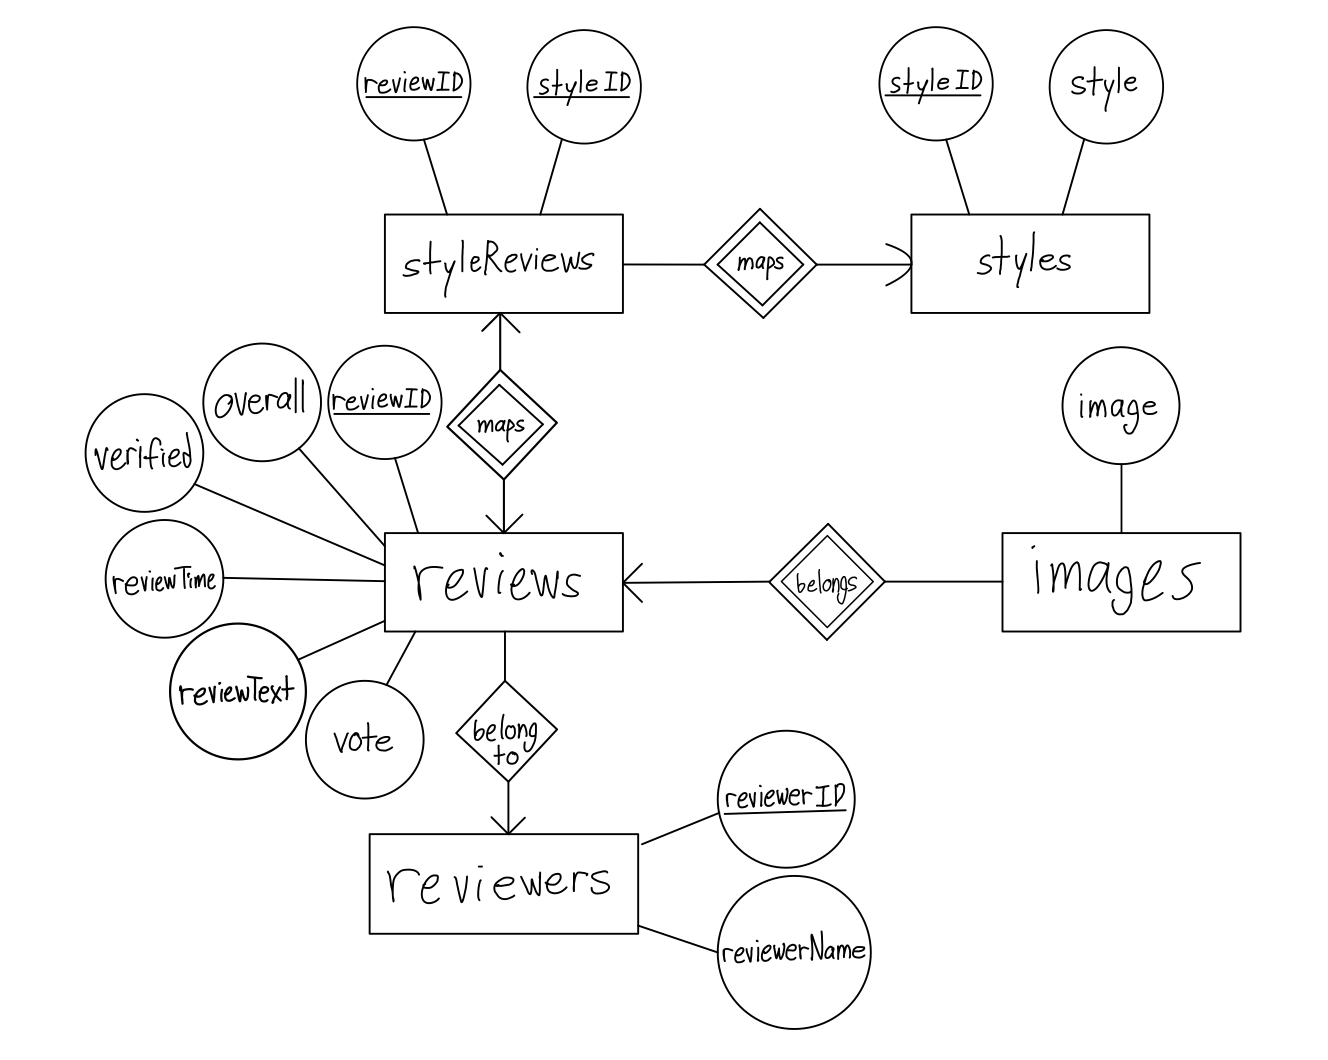

### Temporal Analysis

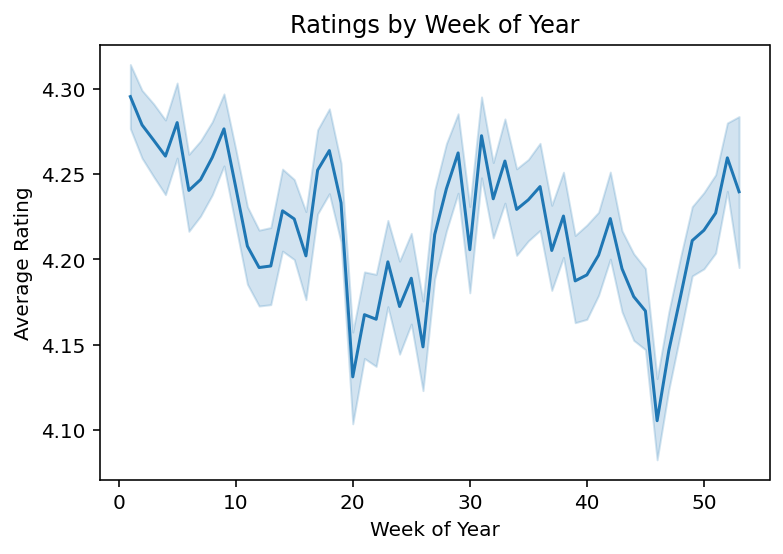

In [73]:
sns.lineplot(x=df['reviewTime'].transform(lambda x: x.week).sort_values(), y=df['overall'])

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Week of Year')
ax.set_ylabel('Average Rating')
ax.set_title('Ratings by Week of Year')

# Show the plot
plt.show()

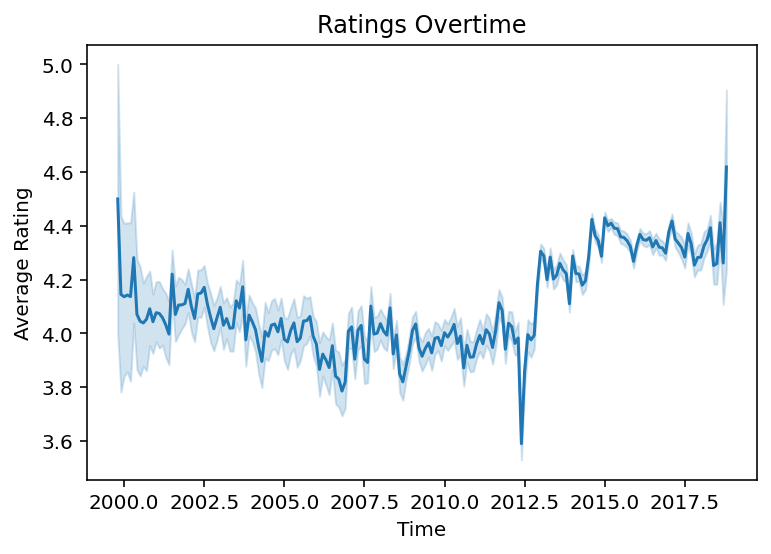

In [74]:
sns.lineplot(x=df['reviewTime'].transform(lambda x: x.year + round(x.week/52, 1)), y=df['overall'])

ax = plt.gca()

# Add labels for the x-axis and y-axis
ax.set_xlabel('Time')
ax.set_ylabel('Average Rating')
ax.set_title('Ratings Overtime')

# Show the plot
plt.show()